In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold # Changed from train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.special import gamma
from typing import Tuple, Dict, List
import collections # For aggregating importances
import re
import shap

In [2]:
# Load the CSV file
df = pd.read_csv("../data/cleanv3_transform.csv")

In [38]:
# Filter out rows where 'INCZERO_ONE' or 'INCZERO_TWO' are equal to 1
df_filtered = df[(df['INCZERO_ONE'] != 1) & (df['INCZERO_TWO'] != 1)]

# Build the main dataframe with continuous target and predictors.
df_data = pd.DataFrame({
    "target": df_filtered["INCLOG_DELTA"],
})

continuous_features = ['INCTOT', 'INCPER', 'INCWAGE', 'FTOTVAL', 'NUMEMPS', 'EDUC', 'AGE', 'UHRSWORKLY', 'HEALTH', 'NCHLT5', 'FIRMSIZE', 'NSIBS', 'NCHILD', 'MTHWELFR', 'FAMSIZE', 'WKSWORK1', 'INCFARM', 'INCASIST', 'INCWKCOM', 'INCWELFR', 'INCOTHER', 'INCEDUC', 'INCDISAB', 'INCRENT', 'INCVET', 'INCCHILD', 'INCSURV', 'INCBUS', 'INCSSI', 'INCDIVID', 'INCUNEMP', 'INCINT', 'INCSS', 'TAXINC', 'ADJGINC']
df_cont = df_filtered[continuous_features].copy()

# Append additional continuous features (columns starting with "occ_" or "ind_")
df_hccat = pd.concat([df_filtered.filter(regex="^(occ_|ind_|occly_|indly_|bpl_|race_)")], axis=1)

# One-hot encode categorical features and add them as predictors.
categorical_features = ['LABFORCE', 'EMPSTAT', 'SEX', 'DIFFANY', 'DIFFMOB', 'DIFFEYE', 'DIFFHEAR', 'DIFFCARE', 'WORKLY', 'DISABWRK', 'QUITSICK', 'VETSTAT', 'DIFFREM', 'DIFFPHYS', 'PENSION', 'FAMKIND', 'FTYPE', 'NATIVITY', 'MIGRATE1', 'CITIZEN', 'FAMREL', 'SCHLCOLL', 'MARST', 'HISPAN', 'RELATE']
ohe = OneHotEncoder(sparse_output=False)
encoded_array = ohe.fit_transform(df_filtered[categorical_features])
encoded_col_names = ohe.get_feature_names_out(categorical_features)
df_cat = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df_filtered.index)

df_data = pd.concat([df_data, df_cont, df_hccat, df_cat], axis=1)

In [ ]:
from IPython.display import display, HTML

# Compute the cardinality (i.e. unique values) for each feature (column)
cardinalities = df_filtered.nunique().sort_values()

# Convert the Series to a DataFrame (for a nicer table display)
card_df = cardinalities.to_frame(name='Cardinality')

# Wrap the table's HTML in a scrollable div
scrollable_table = f'''
<div style="max-height:300px; overflow-y:auto; border:1px solid #ddd; padding:5px;">
  {card_df.to_html()}
</div>
'''

# Display the scrollable table
display(HTML(scrollable_table))

,Cardinality
INCZERO_ONE,1
INCZERO_TWO,1
comp_zero,1
DIFFMOB,2
DIFFEYE,2
DIFFHEAR,2
LABFORCE,2
DIFFCARE,2
DIFFANY,2
WORKLY,2


In [39]:
X = df_data.drop(columns=["target"])
y = df_data["target"]
feature_names = X.columns.tolist()

In [40]:
# Set beta to 0.8 (the only free parameter, with unit scale)
beta = 0.85
eps  = 1e-12  # Small constant for numerical stability

def gnd_objective_func(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
        """
        Calculates alpha-independent gradient and hessian for GND loss.
        """
        y_true = dtrain.get_label()
        diff = y_true - predt
        abs_diff = np.abs(diff)

        # Calculate (|abs_diff| + eps)^(beta - 2) term, crucial for grad and hess
        # Epsilon is vital for stability when beta <= 2
        pow_beta_minus_2 = np.power(abs_diff + eps, beta - 2)

        # --- Gradient Calculation (alpha-independent) ---
        # g_no_alpha = -beta * diff * pow_beta_minus_2
        grad = -beta * diff * pow_beta_minus_2

        # --- Hessian Calculation (alpha-independent) ---
        if beta > 1:
            # h_no_alpha = beta * (beta - 1) * pow_beta_minus_2
            hess = beta * (beta - 1) * pow_beta_minus_2
        elif beta == 1:
            # Replicate reg:absoluteerror behavior
            hess = np.ones_like(predt)
        else: # 0 < beta < 1
            # Use scaled positive approximation
            # h_no_alpha = beta * (1 - beta) * pow_beta_minus_2
            hess = beta * (1 - beta) * pow_beta_minus_2

        # --- Final Hessian Stabilization ---
        # Ensure Hessian is reasonably positive (floor it)
        # Important safeguard, especially for beta <= 1 cases.
        hess = np.maximum(hess, eps)

        return grad, hess

def generalized_normal_metric(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    y = dtrain.get_label()
    valid_indices = ~np.isnan(predt) & ~np.isnan(y)
    if not np.all(valid_indices):
         predt_valid = predt[valid_indices]
         y_valid = y[valid_indices]
    else:
         predt_valid = predt
         y_valid = y
    if len(predt_valid) == 0: return "gnll_eff", np.nan
    loss_term = np.power(np.abs(y_valid - predt_valid), beta)
    mean_loss = float(np.mean(loss_term))
    if np.isnan(mean_loss) or np.isinf(mean_loss): return "gnll_eff", np.nan
    return "gnll_eff", mean_loss

In [41]:
xgb_params = {
    "tree_method": "hist",
    "learning_rate": 0.1,
    "max_depth": 3,
    "min_child_weight": 5000,
    "verbosity": 1,
}

In [42]:
num_round = 5000 # Maximum number of boosting rounds for each fold
early_stopping_rounds = 50

# --- Cross-Validation Setup ---
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Store results from each fold ---
fold_results = []
all_feature_importances = [] # List to store importance dicts from each fold
oof_predictions = np.zeros(len(X)) # Optional: Store Out-of-Fold predictions

In [43]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, feature_names=feature_names)
    dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, feature_names=feature_names)

    print(f"Training fold {fold+1}...")
    watchlist = [(dtrain_fold, "train"), (dval_fold, "val")]

    # --- Capture evaluation results ---
    evals_result = {} # Initialize dict to store results for this fold

    bst_fold = xgb.train(
        params=xgb_params,
        dtrain=dtrain_fold,
        num_boost_round=num_round,
        obj=gnd_objective_func,
        custom_metric=generalized_normal_metric,
        evals=watchlist,
        evals_result=evals_result, # Pass the dict here
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=100
    )

    # --- Correctly access scores from evals_result ---
    best_iter_idx = bst_fold.best_iteration - 1 # best_iteration is 1-based, index is 0-based
    best_score_train = evals_result['train']['gnll_eff'][best_iter_idx]
    # bst_fold.best_score is the validation score at the best iteration
    best_score_val = bst_fold.best_score
    # Or consistently from evals_result: best_score_val = evals_result['val']['gnll_eff'][best_iter_idx]

    fold_results.append({
        'fold': fold + 1,
        'best_iteration': bst_fold.best_iteration,
        'best_score_train': best_score_train,
        'best_score_val': best_score_val
    })
    print(f"Fold {fold+1} Best Iteration: {bst_fold.best_iteration}, Val Score: {best_score_val:.6f}, Train Score: {best_score_train:.6f}")

    importance_scores_fold = bst_fold.get_score(importance_type='gain')
    if importance_scores_fold: # Check if importance scores are available
         all_feature_importances.append(importance_scores_fold)
    else:
         print(f"Warning: No feature importance scores generated for fold {fold+1}")


    # Optional: Store OOF predictions
    # oof_predictions[val_idx] = bst_fold.predict(dval_fold, iteration_range=(0, bst_fold.best_iteration))

print("\nCross-validation finished.")


--- Fold 1/10 ---
Training fold 1...
[0]	train-rmse:0.54439	train-gnll_eff:0.50133	val-rmse:0.54452	val-gnll_eff:0.50104
[100]	train-rmse:0.33062	train-gnll_eff:0.26488	val-rmse:0.33217	val-gnll_eff:0.26528
[200]	train-rmse:0.32328	train-gnll_eff:0.25971	val-rmse:0.32548	val-gnll_eff:0.26058
[300]	train-rmse:0.31796	train-gnll_eff:0.25608	val-rmse:0.32041	val-gnll_eff:0.25731
[400]	train-rmse:0.31626	train-gnll_eff:0.25495	val-rmse:0.31881	val-gnll_eff:0.25634
[500]	train-rmse:0.31527	train-gnll_eff:0.25424	val-rmse:0.31787	val-gnll_eff:0.25575
[600]	train-rmse:0.31413	train-gnll_eff:0.25330	val-rmse:0.31685	val-gnll_eff:0.25492
[700]	train-rmse:0.31359	train-gnll_eff:0.25288	val-rmse:0.31636	val-gnll_eff:0.25455
[800]	train-rmse:0.31307	train-gnll_eff:0.25243	val-rmse:0.31588	val-gnll_eff:0.25415
[900]	train-rmse:0.31287	train-gnll_eff:0.25222	val-rmse:0.31570	val-gnll_eff:0.25398
[1000]	train-rmse:0.31260	train-gnll_eff:0.25190	val-rmse:0.31548	val-gnll_eff:0.25376
[1100]	train-rmse

In [44]:
# --- Aggregate and Display Performance ---
results_df = pd.DataFrame(fold_results)
print("\nCross-Validation Performance Summary:")
print(results_df)
mean_val_score = results_df['best_score_val'].mean()
std_val_score = results_df['best_score_val'].std()
print(f"\nAverage Validation Score (gnll_eff): {mean_val_score:.6f} +/- {std_val_score:.6f}")
mean_train_score = results_df['best_score_train'].mean()
std_train_score = results_df['best_score_train'].std()
print(f"Average Training Score (gnll_eff):   {mean_train_score:.6f} +/- {std_train_score:.6f}")


Cross-Validation Performance Summary:
   fold  best_iteration  best_score_train  best_score_val
0     1            3541          0.247849        0.250754
1     2            3190          0.249170        0.249215
2     3            4495          0.245473        0.247793
3     4            3383          0.246265        0.249712
4     5            4757          0.245792        0.247366
5     6            3520          0.246537        0.250118
6     7            4079          0.246830        0.245818
7     8            3757          0.246459        0.248678
8     9            4765          0.247272        0.249165
9    10            3090          0.246929        0.251032

Average Validation Score (gnll_eff): 0.248965 +/- 0.001612
Average Training Score (gnll_eff):   0.246858 +/- 0.001063



Aggregating feature importance across folds...

Top 20 Features by Average Gain across Folds:
        Feature  Average Importance (Gain)
0     PENSION_2                 736.932699
1    NATIVITY_1                 210.619994
2       INCWAGE                 199.523955
3    SCHLCOLL_4                 189.763492
4    DIFFHEAR_1                 138.496585
5    EMPSTAT_32                 136.650076
6    DISABWRK_1                 128.503818
7      FAMREL_1                 110.531675
8    NATIVITY_4                 106.662766
9        INCPER                 104.939565
10    occ_pca_9                 101.663472
11    occ_pca_4                 101.194084
12        SEX_1                  99.119566
13         EDUC                  93.453486
14   EMPSTAT_10                  91.385160
15    occ_pca_8                  90.761006
16    DIFFANY_1                  81.533281
17    ind_pca_9                  79.084665
18  occly_pca_3                  78.314748
19       INCTOT                  75.296088


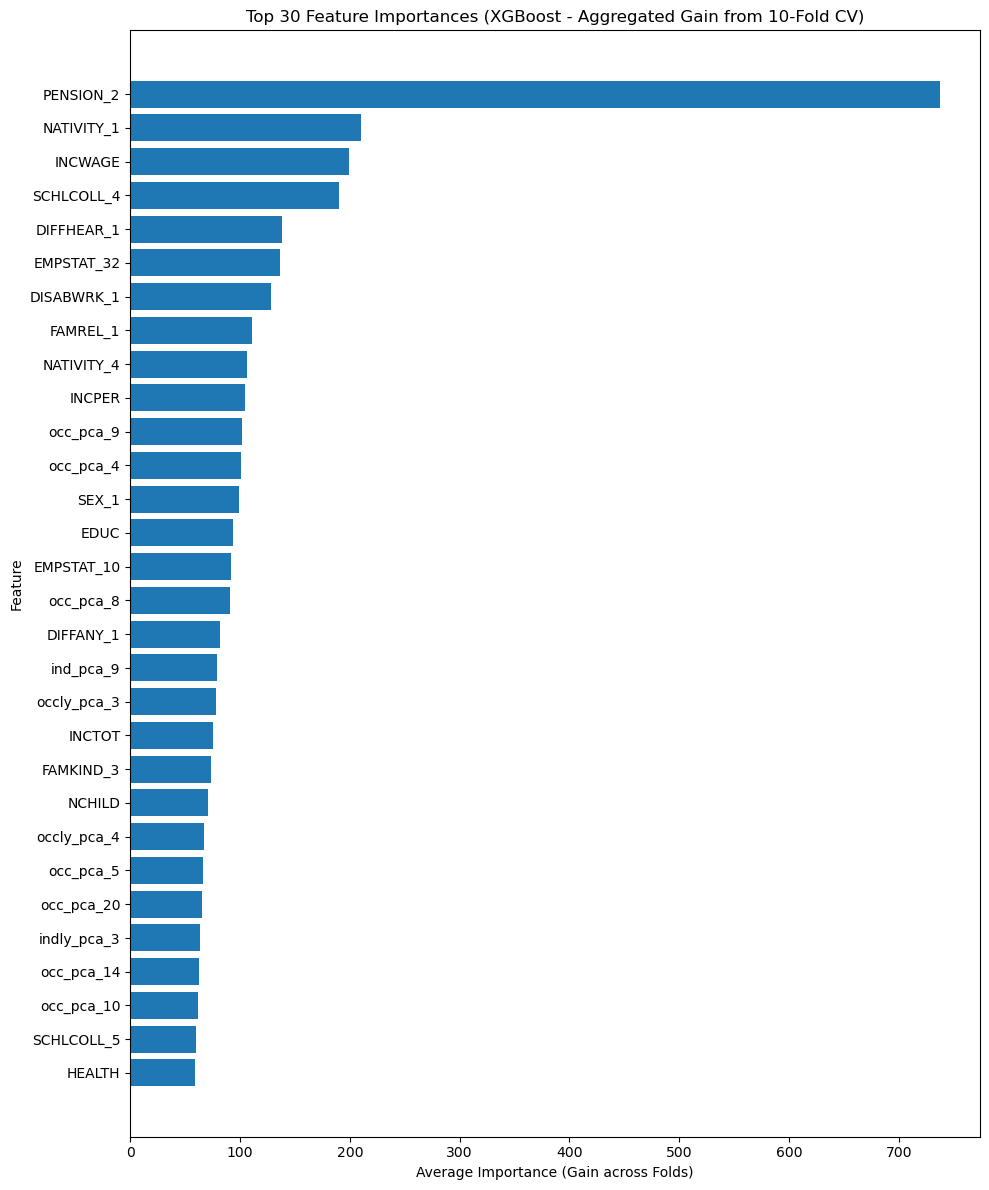

In [45]:
print("\nAggregating feature importance across folds...")
if not all_feature_importances:
     print("Warning: No feature importance scores were collected during CV. Cannot aggregate.")
else:
    aggregated_importance = collections.defaultdict(float)
    # feature_counts = collections.defaultdict(int) # Optional: if needed

    for importance_dict in all_feature_importances:
        for feature, gain in importance_dict.items():
            aggregated_importance[feature] += gain
            # feature_counts[feature] += 1 # Optional

    average_importance = {feature: total_gain / n_splits
                          for feature, total_gain in aggregated_importance.items()}

    if not average_importance:
        print("Warning: Could not aggregate feature importance scores.")
    else:
        avg_importance_df = pd.DataFrame({
            'Feature': list(average_importance.keys()),
            'Average Importance (Gain)': list(average_importance.values())
        })
        avg_importance_df = avg_importance_df.sort_values(by='Average Importance (Gain)', ascending=False).reset_index(drop=True)

        print("\nTop 20 Features by Average Gain across Folds:")
        print(avg_importance_df.head(20))

        top_n = 30
        plt.figure(figsize=(10, max(6, top_n / 2.5))) # Ensure minimum height
        # Filter only top_n existing features before plotting
        plot_df = avg_importance_df.head(top_n)
        plt.barh(plot_df['Feature'][::-1], plot_df['Average Importance (Gain)'][::-1])
        plt.xlabel("Average Importance (Gain across Folds)")
        plt.ylabel("Feature")
        plt.title(f"Top {min(top_n, len(plot_df))} Feature Importances (XGBoost - Aggregated Gain from {n_splits}-Fold CV)")
        plt.tight_layout()
        plt.show()


Aggregating *derived* feature importance across folds...

Aggregating importance for original categorical features...

Top 20 Features/Groups by Aggregated Average Gain across Folds:
   Original Feature / Group  Aggregated Average Importance (Gain)
0                       occ                            980.558915
1                   PENSION                            774.044759
2                     occly                            751.746973
3                     indly                            448.382942
4                       ind                            426.282374
5                  NATIVITY                            319.293014
6                   EMPSTAT                            316.064060
7                  SCHLCOLL                            256.361990
8                   INCWAGE                            199.523955
9                    FAMREL                            184.760711
10                   RELATE                            175.695448
11                 DIFFH

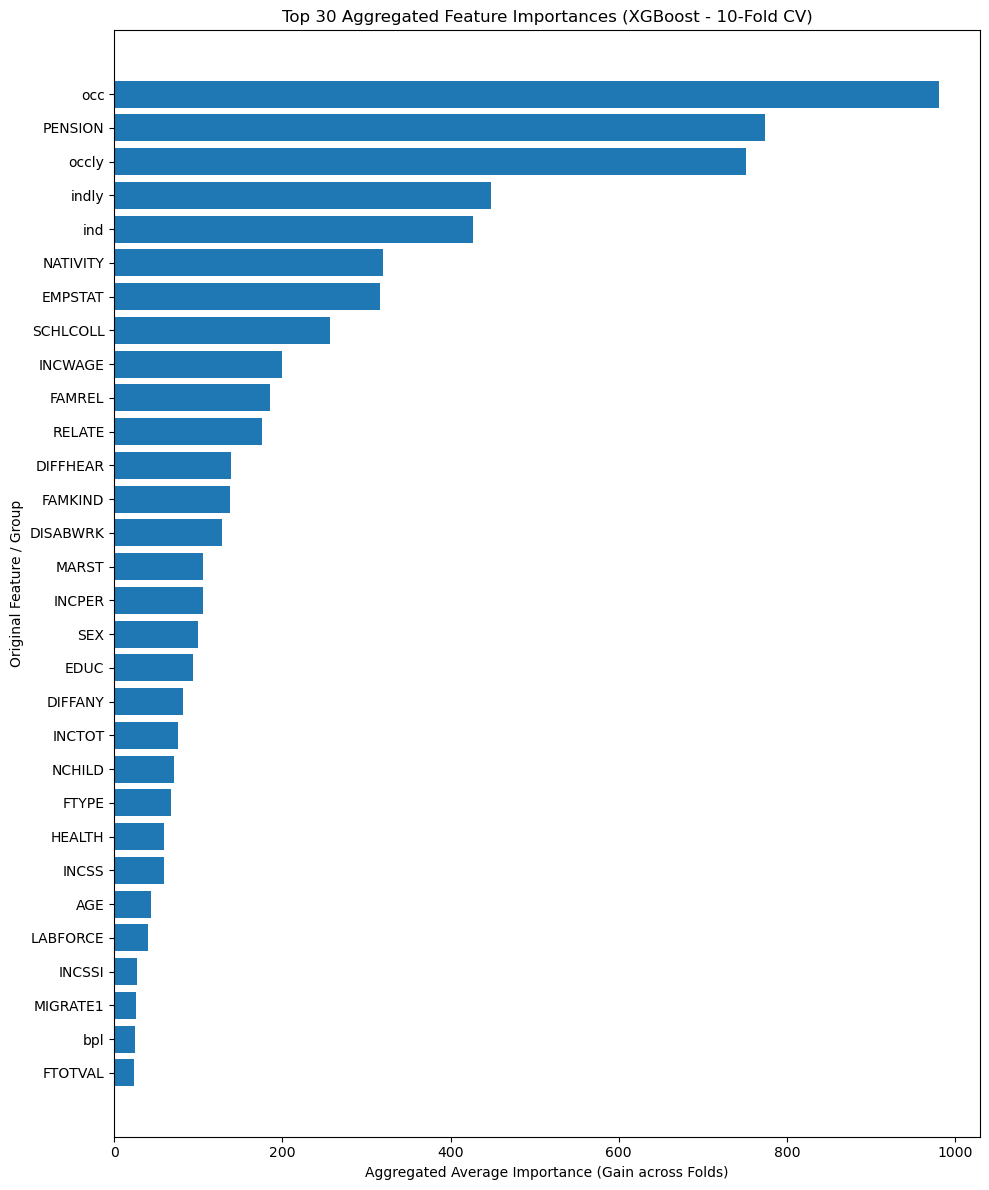


Aggregated feature importance analysis complete.


In [46]:
# --- Aggregate *Derived* Feature Importances (Keep as before) ---
print("\nAggregating *derived* feature importance across folds...")
if not all_feature_importances:
     print("Warning: No feature importance scores were collected during CV. Cannot aggregate.")
     average_importance = {} # Ensure this exists even if empty
else:
    aggregated_importance = collections.defaultdict(float)
    for importance_dict in all_feature_importances:
        for feature, gain in importance_dict.items():
            aggregated_importance[feature] += gain
    average_importance = {feature: total_gain / n_splits
                          for feature, total_gain in aggregated_importance.items()}

# --- NEW CODE: Aggregate Importance by Original Categorical Feature ---

print("\nAggregating importance for original categorical features...")

# Define prefixes for PCA/SBERT based features
pca_sbert_prefixes = ['occ_', 'ind_', 'occly_', 'indly_', 'bpl_', 'race_']

# Create a mapping from derived feature name -> original feature group name
original_feature_map = {}

# Define the list of base categorical features that were one-hot encoded
# (as provided in the user's previous code context)
ohe_base_features = ['DIFFMOB', 'DIFFEYE', 'DIFFHEAR', 'LABFORCE', 'DIFFCARE',
                     'DIFFANY', 'WORKLY', 'DISABWRK', 'QUITSICK', 'VETSTAT',
                     'SEX', 'DIFFREM', 'DIFFPHYS', 'PENSION', 'FAMKIND',
                     'FTYPE', 'NATIVITY', 'MIGRATE1', 'CITIZEN', 'FAMREL',
                     'SCHLCOLL', 'MARST', 'EMPSTAT', 'HISPAN', 'RELATE']

# Create regex patterns for OHE features (e.g., MARST_value, SEX_value)
# Assumes convention featurename_categoryvalue
ohe_patterns = {f: re.compile(f"^{re.escape(f)}_[^_]+$") for f in ohe_base_features}

for derived_feature in average_importance.keys():
    mapped = False
    # 1. Check PCA/SBERT prefixes
    for prefix in pca_sbert_prefixes:
        if derived_feature.startswith(prefix):
            original_feature_map[derived_feature] = prefix.rstrip('_') # Use prefix as group name
            mapped = True
            break
    if mapped: continue

    # 2. Check One-Hot Encoded patterns
    for base_feature, pattern in ohe_patterns.items():
         if pattern.match(derived_feature):
              original_feature_map[derived_feature] = base_feature
              mapped = True
              break
    if mapped: continue

    # 3. If not matched, assume it's a continuous or other feature - keep original name
    original_feature_map[derived_feature] = derived_feature


# Sum importances based on the mapping
aggregated_original_importance = collections.defaultdict(float)
for derived_feature, avg_gain in average_importance.items():
    original_name = original_feature_map.get(derived_feature, derived_feature) # Default to self if somehow not mapped
    aggregated_original_importance[original_name] += avg_gain

# Convert to DataFrame for display and plotting
final_importance_df = pd.DataFrame({
    'Original Feature / Group': list(aggregated_original_importance.keys()),
    'Aggregated Average Importance (Gain)': list(aggregated_original_importance.values())
})

# Sort by aggregated importance
final_importance_df = final_importance_df.sort_values(
    by='Aggregated Average Importance (Gain)', ascending=False
).reset_index(drop=True)


# --- Display and Plot Aggregated *Original* Feature Importance ---

if final_importance_df.empty:
    print("Warning: Final aggregated importance DataFrame is empty.")
else:
    print("\nTop 20 Features/Groups by Aggregated Average Gain across Folds:")
    print(final_importance_df.head(20))

    # --- Plotting the Top N Features/Groups (Aggregated) ---
    top_n_agg = 30
    plt.figure(figsize=(10, max(6, top_n_agg / 2.5)))
    plot_df_agg = final_importance_df.head(top_n_agg)
    plt.barh(plot_df_agg['Original Feature / Group'][::-1], plot_df_agg['Aggregated Average Importance (Gain)'][::-1])
    plt.xlabel("Aggregated Average Importance (Gain across Folds)")
    plt.ylabel("Original Feature / Group")
    plt.title(f"Top {min(top_n_agg, len(plot_df_agg))} Aggregated Feature Importances (XGBoost - {n_splits}-Fold CV)")
    plt.tight_layout()
    plt.show()

    # Optional: Save aggregated importance scores
    # final_importance_df.to_csv("feature_importance_gnd_model_cv_aggregated.csv", index=False)
    # print("\nAggregated original feature importance scores saved.")

print("\nAggregated feature importance analysis complete.")

In [52]:
# Calculate the total importance sum
total_importance = final_importance_df['Aggregated Average Importance (Gain)'].sum()

if total_importance > 0:
    # Calculate the percentage contribution of each feature/group
    final_importance_df['Percentage'] = (final_importance_df['Aggregated Average Importance (Gain)'] / total_importance) * 100

    # Calculate the cumulative percentage
    final_importance_df['Cumulative Percentage'] = final_importance_df['Percentage'].cumsum()

    # Define the threshold
    threshold = 95.0

    # Find the index where cumulative percentage first reaches or exceeds the threshold
    # Add a small tolerance in case of floating point issues near 99.0
    try:
        cutoff_index = final_importance_df[final_importance_df['Cumulative Percentage'] >= (threshold - 1e-9)].index[0]
        # Select features up to and including the cutoff index
        selected_features_df_99 = final_importance_df.iloc[:cutoff_index + 1]

        print(f"\n--- Features Contributing to {threshold:.1f}% of Total Importance ---")
        print(f"{'Feature/Group':<30} | {'Individual %':<15}")
        print("-" * 50)
        for index, row in selected_features_df_99.iterrows():
            print(f"{row['Original Feature / Group']:<30} | {row['Percentage']:.4f}%")
        print("-" * 50)
        print(f"Number of features/groups selected: {len(selected_features_df_99)}")
        print(f"Actual cumulative importance: {selected_features_df_99['Cumulative Percentage'].iloc[-1]:.4f}%")
        print("-" * 50)

    except IndexError:
        print(f"Warning: Could not find features reaching the {threshold}% threshold.")
        print("Displaying all features sorted by importance:")
        print(f"{'Feature/Group':<30} | {'Individual %':<15}")
        print("-" * 50)
        for index, row in final_importance_df.iterrows():
                print(f"{row['Original Feature / Group']:<30} | {row['Percentage']:.4f}%")
        print("-" * 50)



--- Features Contributing to 95.0% of Total Importance ---
Feature/Group                  | Individual %   
--------------------------------------------------
occ                            | 15.1120%
PENSION                        | 11.9293%
occly                          | 11.5856%
indly                          | 6.9103%
ind                            | 6.5697%
NATIVITY                       | 4.9208%
EMPSTAT                        | 4.8711%
SCHLCOLL                       | 3.9510%
INCWAGE                        | 3.0750%
FAMREL                         | 2.8475%
RELATE                         | 2.7078%
DIFFHEAR                       | 2.1345%
FAMKIND                        | 2.1172%
DISABWRK                       | 1.9805%
MARST                          | 1.6300%
INCPER                         | 1.6173%
SEX                            | 1.5276%
EDUC                           | 1.4403%
DIFFANY                        | 1.2566%
INCTOT                         | 1.1604%
NCHILD           

In [53]:
if total_importance > 0 and 'cutoff_index' in locals():
    # Select features *after* the cutoff index
    excluded_features_df = final_importance_df.iloc[cutoff_index + 1:]

    if not excluded_features_df.empty:
        print(f"\n--- Features/Groups *NOT* Included in Top {threshold:.1f}% Importance ---")
        excluded_feature_list = excluded_features_df['Original Feature / Group'].tolist()
        print(f"Number of excluded features/groups: {len(excluded_feature_list)}")
        # Print the list (optional, can be long)
        for feature_name in excluded_feature_list:
            print(f"- {feature_name}")
    else:
        print(f"\nAll features were included within the {threshold:.1f}% importance threshold.")
        print("-" * 50)


--- Features/Groups *NOT* Included in Top 95.0% Importance ---
Number of excluded features/groups: 37
- bpl
- FTOTVAL
- INCINT
- HISPAN
- NCHLT5
- DIFFPHYS
- FAMSIZE
- race
- ADJGINC
- INCDIVID
- FIRMSIZE
- INCBUS
- UHRSWORKLY
- NUMEMPS
- NSIBS
- WKSWORK1
- CITIZEN
- VETSTAT
- TAXINC
- DIFFMOB
- QUITSICK
- INCEDUC
- INCRENT
- MTHWELFR
- INCUNEMP
- INCCHILD
- DIFFREM
- INCSURV
- INCASIST
- INCVET
- INCDISAB
- INCFARM
- INCWELFR
- INCOTHER
- INCWKCOM
- DIFFEYE
- DIFFCARE


In [ ]:
num_round = 3000  # Number of boosting rounds

# Use xgb.train() with our custom objective and evaluation metric.
bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    obj=gnd_objective_func,
    custom_metric = generalized_normal_metric,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50
)

[0]	train-rmse:0.55130	train-gnll:0.50596	val-rmse:0.54964	val-gnll:0.50520
[1]	train-rmse:0.50890	train-gnll:0.46080	val-rmse:0.50719	val-gnll:0.46009
[2]	train-rmse:0.49046	train-gnll:0.44093	val-rmse:0.48878	val-gnll:0.44029
[3]	train-rmse:0.47111	train-gnll:0.41975	val-rmse:0.46939	val-gnll:0.41903
[4]	train-rmse:0.45364	train-gnll:0.40142	val-rmse:0.45194	val-gnll:0.40069
[5]	train-rmse:0.44234	train-gnll:0.38917	val-rmse:0.44060	val-gnll:0.38838
[6]	train-rmse:0.43210	train-gnll:0.37800	val-rmse:0.43035	val-gnll:0.37710
[7]	train-rmse:0.42282	train-gnll:0.36761	val-rmse:0.42107	val-gnll:0.36669
[8]	train-rmse:0.41528	train-gnll:0.35890	val-rmse:0.41348	val-gnll:0.35790
[9]	train-rmse:0.40794	train-gnll:0.35075	val-rmse:0.40622	val-gnll:0.34975
[10]	train-rmse:0.40280	train-gnll:0.34480	val-rmse:0.40114	val-gnll:0.34380
[11]	train-rmse:0.39747	train-gnll:0.33880	val-rmse:0.39579	val-gnll:0.33772
[12]	train-rmse:0.39318	train-gnll:0.33360	val-rmse:0.39146	val-gnll:0.33243
[13]	trai